# Dataset Creation using Google Earth Engine API

## Install Google Earth Engine API

In [ ]:
!pip install earthengine-api --upgrade

## Authenicate & Ping

In [2]:
import ee
ee.Authenticate()
ee.Initialize(project='satellitepredictor')

In [3]:
print(ee.String('Hello from the Earth Engine servers!').getInfo())

Hello from the Earth Engine servers!


## Import Libraries

In [4]:
import folium
import geemap
import time
import datetime
from PIL import Image
import requests
import numpy as np
import os
from google.colab import files

## Utilities

In [5]:
def define_region(longitude, latitude, metersPerPixel, imageDimensions):
  coords = ee.Geometry.Point(longitude, latitude)
  dist = (metersPerPixel * imageDimensions) / 2.
  # distance in buffer refers to meters, and expands from center 2*dist
  # Create a region of interest around the point
  region = coords.buffer(distance=dist).bounds() # Buffer distance in meters
  return coords, region

In [6]:
image_collections = {
    "copernicus": ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED'),
    "landsat9": ee.ImageCollection('LANDSAT/LC09/C02/T1'),
    "viirs_annual": ee.ImageCollection("NOAA/VIIRS/DNB/ANNUAL_V22"),
    "viirs_monthly": ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG"),
}

In [7]:
def generate_coordinates_vec(start_coords, end_coords, step_meters):
  """
  Generates intermediate coordinates between a start and end point at fixed step distances.
  Parameters:
      start_coords (tuple): (longitude, latitude) of the start point.
      end_coords (tuple): (longitude, latitude) of the end point.
      step_meters (float): Distance between consecutive points in meters.
  Returns:
      List of (longitude, latitude) tuples.
  """
  # Convert (lon, lat) to EE Points
  start_point = ee.Geometry.Point(start_coords)
  end_point = ee.Geometry.Point(end_coords)
  # Get distance between points in meters
  total_distance = start_point.distance(end_point).getInfo()
  # Compute number of steps
  num_steps = int(total_distance // step_meters)
  # Compute vector step in lon/lat space
  lon_step = (end_coords[0] - start_coords[0]) / num_steps
  lat_step = (end_coords[1] - start_coords[1]) / num_steps
  # Generate coordinates along the path
  coordinates = [
      (start_coords[0] + i * lon_step, start_coords[1] + i * lat_step)
      for i in range(num_steps + 1)
  ]
  return coordinates

In [8]:
def generate_coordinates_box(start_coords, end_coords, step_meters):
  """
  Generates intermediate coordinates between a start and end point at fixed step distances.
  Parameters:
      start_coords (tuple): (longitude, latitude) of the start point.
      end_coords (tuple): (longitude, latitude) of the end point.
      step_meters (float): Distance between consecutive points in meters.
  Returns:
      List of (longitude, latitude) tuples.
  """
  # Convert (lon, lat) to EE Points
  start_point = ee.Geometry.Point(start_coords)
  end_point = ee.Geometry.Point(end_coords)
  # find longitude and latitude distance in meters
  lon_distance_meters = start_point.distance(ee.Geometry.Point(
      [end_coords[0], start_coords[1]])).getInfo() # Use a list for coordinates
  lat_distance_meters = start_point.distance(ee.Geometry.Point(
      [start_coords[0], end_coords[1]])).getInfo() # Use a list for coordinates
  # find number of steps for longitude and latitude
  num_steps_lon = int(lon_distance_meters // step_meters)
  num_steps_lat = int(lat_distance_meters // step_meters)
  # Handle cases where num_steps is 0 to avoid ZeroDivisionError
  if num_steps_lon == 0:
    num_steps_lon = 1
  if num_steps_lat == 0:
    num_steps_lat = 1
  # Compute step in lon/lat space
  lon_step = (end_coords[0] - start_coords[0]) / num_steps_lon
  lat_step = (end_coords[1] - start_coords[1]) / num_steps_lat
  # generate coordinates
  coordinates = []
  for i in range(num_steps_lon + 1):
    for j in range(num_steps_lat + 1):
      lon = start_coords[0] + i * lon_step
      lat = start_coords[1] + j * lat_step
      coordinates.append((lon, lat))
  return coordinates

In [9]:
def collect_images_VIIRS(region, imageDimensions, start_date, end_date):
  """
  Collects and downloads a VIIRS image for a given region.

  Args:
      coords (ee.Geometry.Point): Center point coordinates.
      region (ee.Geometry): Region polygon.

  Returns:
      PIL.Image.Image: Downloaded VIIRS image.
  """
  # Load VIIRS image collection (using predefined image_collections dictionary)
  image_collection = image_collections['viirs_monthly'].filterBounds(region).filterDate(start_date, end_date)
  image_collection = (image_collections['viirs_monthly']
                    .filterBounds(region)
                    .filterDate(start_date, end_date)
                    .sort('CLOUDY_PIXEL_PERCENTAGE', False))  # Sort by cloud cover percentage (ascending)
  try:
      image = ee.Image(image_collection.first())
  except Exception as e:
      print(f"Error retrieving image: {e}")
      return None  # Return None in case of error
  # Download image using getThumbURL
  image_url = image.getThumbURL({
      "format": "png",
      "bands": ["avg_rad"],
      "dimensions": imageDimensions,
      "region": region,
      "min": 0,
      "max": 60,
  })
  try:
      image_thumbURL_response = requests.get(image_url, stream=True)
      img_pil = Image.open(image_thumbURL_response.raw)
      return img_pil
  except requests.exceptions.RequestException as e:
      print(f"Error downloading image: {e}")
      return None  # Return None in case of error

In [10]:
def save_image(img, root_name, region_name, img_name):
  folder_path = os.path.join(root_name, region_name)
  # Create the folder if it doesn't exist
  os.makedirs(folder_path, exist_ok=True)
  image_path = os.path.join(folder_path, img_name)
  img.save(image_path)

In [11]:
def download_images_locally(path):
  # zip content
  os.system(f"zip -r /content/images.zip /content/{path}")
  # download zip
  files.download("/content/images.zip")

## Download Night-time Image (VIIRS Dataset)

In [12]:
# Coordinates for Thessaloniki, Greece
longitude = 23.678010
latitude = 38.011885
# parameters for VIIRS dataset
metersPerPixel = 450  # meters
imageDimensions = 1800 # pixels

# Create a geometry point for the coordinates
coords, region = define_region(longitude, latitude,
                               metersPerPixel, imageDimensions)

region.getInfo()

{'geodesic': False,
 'type': 'Polygon',
 'coordinates': [[[19.076225203136815, 34.36868024988846],
   [28.29983812707089, 34.36868024988846],
   [28.29983812707089, 41.65642571035001],
   [19.076225203136815, 41.65642571035001],
   [19.076225203136815, 34.36868024988846]]]}

In [13]:
# Load Sentinel-2 image collection
image_collection = (image_collections['viirs_monthly']
                    .filterBounds(region)
                    .filterDate('2022-01-01', '2025-01-01')  # Time range
                    .sort('CLOUDY_PIXEL_PERCENTAGE', False)
                    )  # Select RGB bands

image = ee.Image(image_collection.first())
print("Image Info is a ", type(image.getInfo()))
print("Fields of Image Info:")
for key in image.getInfo():
    print(key)

Image Info is a  <class 'dict'>
Fields of Image Info:
type
bands
version
id
properties


In [14]:
image

In [15]:
print("Start time of Image:\t", image.getInfo()["properties"]["system:time_start"])

print(
    "Date:\t\t\t",
    datetime.datetime.fromtimestamp(
        image.getInfo()["properties"]["system:time_start"] / 1000
    ).strftime("%c"),
)

print("VIIRS ID:\t\t", image.getInfo()["properties"]["system:index"])

Start time of Image:	 1640995200000
Date:			 Sat Jan  1 00:00:00 2022
VIIRS ID:		 20220101


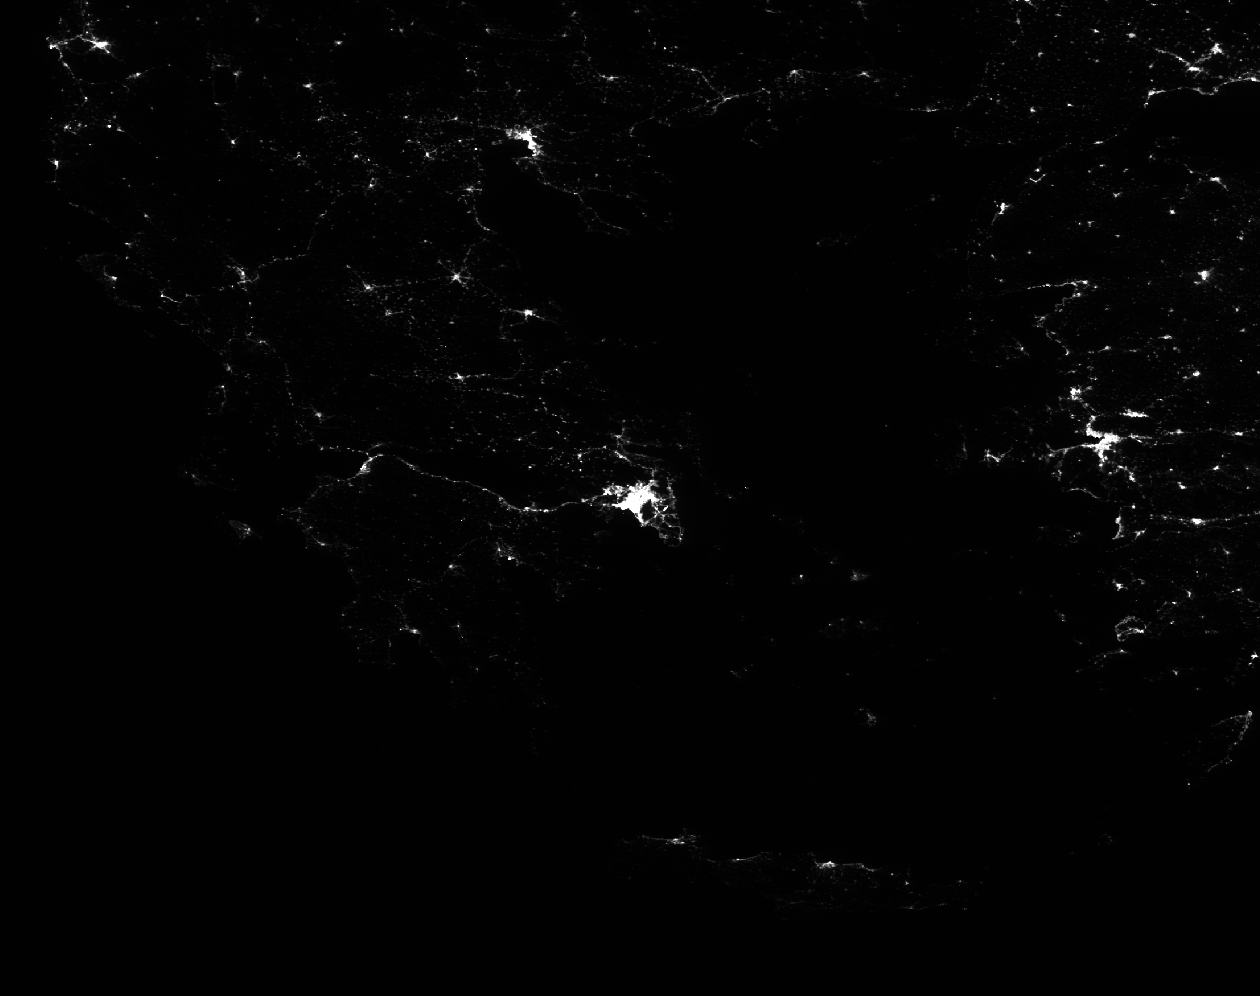

Satellite image (VIIRS) for Greece


In [16]:
# Get the thumbnail URL
image_url = image.getThumbURL(
    {
        "format": "png",
        "bands": ["avg_rad"],  # Use the 'avg_rad' band for radiance
        "dimensions": imageDimensions*0.7,
        "region": region,
        "min": 0,
        "max": 60,  # Adjust max value as needed
        # 'palette': ['000000','ffffff']
    }
)

# Download and display the image
try:
    image_thumbURL_response = requests.get(image_url, stream=True)
    DC_PIL = Image.open(image_thumbURL_response.raw)
    display(DC_PIL)  # Display in Colab.
    print("Satellite image (VIIRS) for Greece")
except requests.exceptions.RequestException as e:
    print(f"Error downloading image: {e}")

In [ ]:
# save image locally
save_image(DC_PIL, 'Thess', 'thess1.png')


## Download Night-time Images for Defined Region

In [28]:
# dictionary for requested countries
countries_dict = {
    "Albania": {"start_coords": (19.297, 39.625), "end_coords": (20.334, 42.293), "code": 'al', "name": 'Albania'},
    "Austria": {"start_coords": (12.205, 46.930), "end_coords": (16.638, 48.704), "code": 'at', "name": 'Austria'},
    "Belgium": {"start_coords": (2.539, 50.497), "end_coords": (5.706, 51.353), "code": 'be', "name": 'Belgium'},
    "Bosnia": {"start_coords": (17.237, 43.552), "end_coords": (18.521, 44.876), "code": 'ba', "name": 'Bosnia'},
    "Bulgaria": {"start_coords": (23.039, 41.440), "end_coords": (27.874, 43.925), "code": 'bg', "name": 'Bulgaria'},
    "England": {"start_coords": (-2.679, 49.961), "end_coords": (-1.768, 55.812), "code": 'gb', "name": 'England'},
    "France": {"start_coords": (-1.061, 44.367), "end_coords": (6.560, 49.090), "code": 'fr', "name": 'France'},
    "Germany": {"start_coords": (7.866, 48.270), "end_coords": (14.042, 53.058), "code": 'de', "name": 'Germany'},
    "Greece": {"start_coords": (21.252, 40.352), "end_coords": (25.863, 41.084), "code": 'gr', "name": 'Greece'},
    "Hungary": {"start_coords": (17.104, 46.754), "end_coords": (21.891, 48.583), "code": 'hu', "name": 'Hungary'},
    "Italy": {"start_coords": (8.626, 39.496), "end_coords": (13.521, 46.092), "code": 'it', "name": 'Italy'},
    "Montenegro": {"start_coords": (18.429, 42.166), "end_coords": (19.624, 43.553), "code": 'me', "name": 'Montenegro'},
    "Netherlands": {"start_coords": (4.350, 51.750), "end_coords": (7.220, 53.560), "code": 'nl', "name": 'Netherlands'},
    "FYROM": {"start_coords": (20.259, 41.862), "end_coords": (22.327, 42.385), "code": 'fy', "name": 'FYROM'},
    "Poland": {"start_coords": (16.425, 50.501), "end_coords": (22.146, 54.836), "code": 'pl', "name": 'Poland'},
    "Portugal": {"start_coords": (-9.526, 37.959), "end_coords": (-6.192, 41.154), "code": 'pt', "name": 'Portugal'},
    "Romania": {"start_coords": (22.264, 44.639), "end_coords": (26.648, 47.261), "code": 'ro', "name": 'Romania'},
    "Serbia": {"start_coords": (19.828, 43.858), "end_coords": (21.008, 45.167), "code": 'rs', "name": 'Serbia'},
    "Spain": {"start_coords": (-7.385, 37.992), "end_coords": (0.320, 42.775), "code": 'es', "name": 'Spain'},
}

In [ ]:
start_coords = (21.252095, 40.352132)
end_coords = (25.863077, 41.084245)
metersPerPixel = 450  # meters
imageDimensions = 400 # pixels
coords = generate_coordinates_vec(start_coords, end_coords, step_meters=1e5)
years = range(2014, 2025)

for i, c in enumerate(coords):
  coords, region = define_region(c[0], c[1], 450, 400)
  for year in years:
    start_date = str(year) + '-01-01'
    end_date = str(year) + '-12-31'
    img = collect_images_VIIRS(region, imageDimensions, start_date, end_date)
    save_image(img, 'VIIRS', 'Greece', 'gr' + str(i) + "-" + start_date + '.png')

In [ ]:
start_coords = (21.206779, 35.391382)
end_coords = (25.988576, 41.189829)
metersPerPixel = 450  # meters
imageDimensions = 400 # pixels
coords = generate_coordinates_box(start_coords, end_coords, step_meters=1e5)
years = range(2014, 2024)

for i, c in enumerate(coords):
  coords, region = define_region(c[0], c[1], 450, 400)
  for year in years:
    start_date = str(year) + '-01-01'
    end_date = str(year) + '-12-31'
    img = collect_images_VIIRS(region, imageDimensions, start_date, end_date)
    save_image(img, 'VIIRS', 'Greece', 'gr' + str(i) + "-" + start_date + '.png')

In [29]:
metersPerPixel = 450  # meters
imageDimensions = 400 # pixels
years = range(2014, 2024)

for country_name, country_data in countries_dict.items():
    start_coords = country_data["start_coords"]
    end_coords = country_data["end_coords"]
    country_code = country_data["code"]

    coords = generate_coordinates_box(start_coords, end_coords, step_meters=1e5)

    for i, c in enumerate(coords):
        coords, region = define_region(c[0], c[1], 450, 400)
        for year in years:
            start_date = str(year) + '-01-01'
            end_date = str(year) + '-12-31'
            img = collect_images_VIIRS(region, imageDimensions, start_date, end_date)
            # Save with country code and index
            save_image(img, 'VIIRS', country_name, country_code + str(i) + "-" + str(year) + '.png')

In [30]:
download_images_locally('VIIRS/')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
import shutil

try:
    shutil.rmtree('/content/VIIRS')
    print("Folder 'VIIRS' deleted successfully.")
except OSError as e:
    print(f"Error deleting folder: {e}")

Folder 'VIIRS' deleted successfully.


## Download Day Image (Copernicus)

In [ ]:
# Coordinates for Thessaloniki, Greece
longitude = 22.9475
latitude = 40.6302
# parameters for Copernicus dataset
metersPerPixel = 10  # meters
imageDimensions = 400 # pixels

# Create a geometry point for the coordinates
coords, region = define_region(longitude, latitude,
                               metersPerPixel, imageDimensions)

region.getInfo()

{'geodesic': False,
 'type': 'Polygon',
 'coordinates': [[[22.92397916717062, 40.612209182620866],
   [22.971096941039338, 40.612209182620866],
   [22.971096941039338, 40.64819773190299],
   [22.92397916717062, 40.64819773190299],
   [22.92397916717062, 40.612209182620866]]]}

In [ ]:
# Load Sentinel-2 image collection
image_collection = (image_collections['copernicus']
                    .filterBounds(region)
                    .filterDate('2022-03-01', '2025-03-1')  # Time range
                    .filter(ee.Filter.lte("CLOUDY_PIXEL_PERCENTAGE", 10))
                    .sort('CLOUD_COVER')
                    .select(['B4', 'B3', 'B2'])
                    )  # Select RGB bands

try:
    image = ee.Image(image_collection.first())
    print("Image Info is a ", type(image.getInfo()))
    print("Fields of Image Info:")
    for key in image.getInfo():
        print(key)
except Exception as e:
    print(f"Error retrieving image: {e}")

Image Info is a  <class 'dict'>
Fields of Image Info:
type
bands
version
id
properties


In [ ]:
print("Start time of Image:\t", image.getInfo()["properties"]["system:time_start"])

print(
    "Date:\t\t\t",
    datetime.datetime.fromtimestamp(
        image.getInfo()["properties"]["system:time_start"] / 1000
    ).strftime("%c"),
)

print("Sentinel ID:\t\t", image.getInfo()["properties"]["DATATAKE_IDENTIFIER"])

Start time of Image:	 1647250151376
Date:			 Mon Mar 14 09:29:11 2022
Sentinel ID:		 GS2A_20220314T092031_035125_N04.00


In [ ]:
image

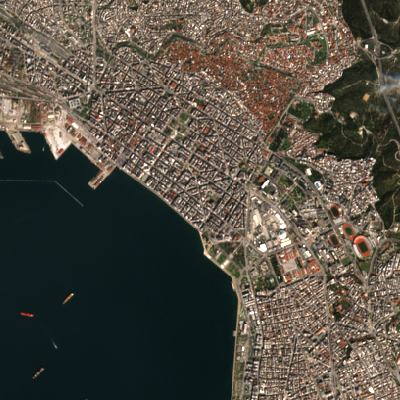

In [ ]:
image_url = image.getThumbURL(
    {
        "format": "png",
        "bands": ["B4", "B3", "B2"],
        "dimensions": imageDimensions,
        "region": region,
        "min": 0,
        "max": 3000,
    }
)

try:
    image_thumbURL_response = requests.get(image_url, stream=True)
    DC_PIL = Image.open(image_thumbURL_response.raw)
    display(DC_PIL)  # Display in Colab
except requests.exceptions.RequestException as e:
    print(f"Error downloading image: {e}")

## Unecessary Utilities

In [ ]:
pixels = 720

# Export the image to Google Drive
# Export image as GeoTIFF to Google Drive
task = ee.batch.Export.image.toDrive(
    image=image.visualize(min=0, max=3000, gamma=1.4),
    description='Thessaloniki_S2_TIFF',
    folder='EarthEngineImages',
    fileNamePrefix='thessaloniki_1km',
    region=region,
    scale=dist / pixels,
    # dimensions='720x720',  # 720-pixel resolution
    maxPixels: 1e7,
    fileFormat='GeoTIFF'  # Change format to GeoTIFF
)

# task = ee.Export.image.toDrive(
#     image=image,
#     description='Thessaloniki_Image',
#     folder='EarthEngineImages',
#     fileNamePrefix='thessaloniki'
#     region=region,
#     scale=10,  # Set the scale (zoom level)
#     # maxPixels=1e13,  # Increase the maxPixels value if needed
#     fileFormat='GeoTIFF'
# )

task.start()
print('Downloading image to Google Drive. Task ID:', task.id)

# Check status until completed
while task.status()['state'] in ['READY', 'RUNNING']:
    print("Processing...")
    time.sleep(10)  # Check every 1 seconds

# Print completion message
if task.status()['state'] == 'COMPLETED':
    file_path = f"Google Drive -> EarthEngineImages -> thessaloniki_1km.png"
    print(f"Download completed! Image saved at: {file_path}")
else:
    print(f"Export failed: {task.status()}")

In [ ]:
task.status()

{'state': 'COMPLETED',
 'description': 'Thessaloniki_S2_TIFF',
 'priority': 100,
 'creation_timestamp_ms': 1743094616623,
 'update_timestamp_ms': 1743094684754,
 'start_timestamp_ms': 1743094631127,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/#folders/1UZSMw3J3QA-TP2gW8pPWeoRCx_BUcn6G'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 3.7145135402679443,
 'id': 'LIGNDLMTP7UCQHOFL5V3GS57',
 'name': 'projects/satellitepredictor/operations/LIGNDLMTP7UCQHOFL5V3GS57'}

In [ ]:
from PIL import Image
import numpy as np
import cv2
import gdown

# Mount Google Drive
from google.colab import drive

# Define paths
tiff_path = "/content/drive/My Drive/EarthEngineImages/thessaloniki_1km.tif"
png_path = "/content/drive/My Drive/EarthEngineImages/thessaloniki_1km.png"

# Open the GeoTIFF image
tiff_image = Image.open(tiff_path)

# Convert to PNG
tiff_image.save(png_path, "PNG")

print(f"Conversion completed! PNG saved at: {png_path}")

Conversion completed! PNG saved at: /content/drive/My Drive/EarthEngineImages/thessaloniki_1km.png


In [ ]:
def define_regionV2(longitude, latitude, metersPerPixel, imageDimensions, image):
    """
    Defines a region around a given point with proper projection handling.

    Parameters:
        longitude (float): Longitude of the center point.
        latitude (float): Latitude of the center point.
        metersPerPixel (float): Desired meters per pixel.
        imageDimensions (int): The width/height of the image in pixels.
        image (ee.Image): The image to extract the projection from.

    Returns:
        ee.Geometry.Point: Center point.
        ee.Geometry: Region polygon with correct projection.
    """
    coords = ee.Geometry.Point(longitude, latitude)

    # Compute half the total distance to cover
    dist = (metersPerPixel * imageDimensions) / 2.0

    # Get projection from the provided image (ensures correct spatial reference)
    proj = image.projection()

    # Buffer and reproject to match the image's coordinate system
    region = coords.buffer(distance=dist, proj=proj).bounds(maxError=1e-3)  # Add small error margin

    return coords, region